In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from IPython.display import Math, Latex

print(f"Running on PyMC3 v{pm.__version__}")

#original is here:
# https://docs.pymc.io/notebooks/data_container.html

Running on PyMC3 v3.10.0


# The Data Class
The Data container class wraps the theano shared variable class and lets the model be aware of its inputs and outputs. This allows one to change the value of an observed variable to predict or refit on new data. All variables of this class must be declared inside a model context and specify a name for them.

Its pretty hard to find good examples of using this class in models.  Hopefully this notebook helps people.

In [19]:
#print(data)
#stats.describe(data)
# total_bill and tip are float, everything else is categorical
df = pd.read_csv('./data/tips.csv')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [20]:
# Categorical Mapping
def remap(df, fields):
    lookups = {}  #a dictionary of lookup tables (also dictionaries), field:lookup_table
    #create the lookups
    for field in fields:
        uniques = df[field].unique()
        print(field)
        print(uniques)
        lookup = dict(zip(uniques, range(len(uniques))))  #create simple map to convert names to numbers
        lookups[field] = lookup
    #use the lookups to modify the dataframe and return the modified version
    for field in fields:
        df[field] = df[field].map(lookups[field])
    return df, lookups


df, _ = remap(df, ["sex", "smoker", "day", "time"])
df
#adiag_names = df[adiag_field].unique()
#print(adiag_names)
#print(len(adiag_names))
#adiag_lookup = dict(zip(adiag_names, range(len(adiag_names))))  #create simple map to convert names to numbers

sex
['Female' 'Male']
smoker
['No' 'Yes']
day
['Sun' 'Sat' 'Thur' 'Fri']
time
['Dinner' 'Lunch']


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,0,0,2
1,10.34,1.66,1,0,0,0,3
2,21.01,3.50,1,0,0,0,3
3,23.68,3.31,1,0,0,0,2
4,24.59,3.61,0,0,0,0,4
...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,1,0,3
240,27.18,2.00,0,1,1,0,2
241,22.67,2.00,1,1,1,0,2
242,17.82,1.75,1,0,1,0,2


In [27]:
df.describe()

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,0.643443,0.381148,1.098361,0.278689,2.569672
std,8.902412,1.383638,0.479967,0.486667,0.933244,0.449276,0.951100
min,3.070000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.347500,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,17.795000,2.900000,1.000000,0.000000,1.000000,0.000000,2.000000
75%,24.127500,3.562500,1.000000,1.000000,2.000000,1.000000,3.000000
max,50.810000,10.000000,1.000000,1.000000,3.000000,1.000000,6.000000


In [38]:
coords = {'total_bill':df['total_bill'],
          'tip':df['tip'],
          'sex':df['sex'],
          'smoker':df['smoker'],
          'day':df['day'],
          'time':df['time'],
          'size':df['size']
         }


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 11 seconds.
/Users/m102417/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9598a07640>,
      dtype=object)

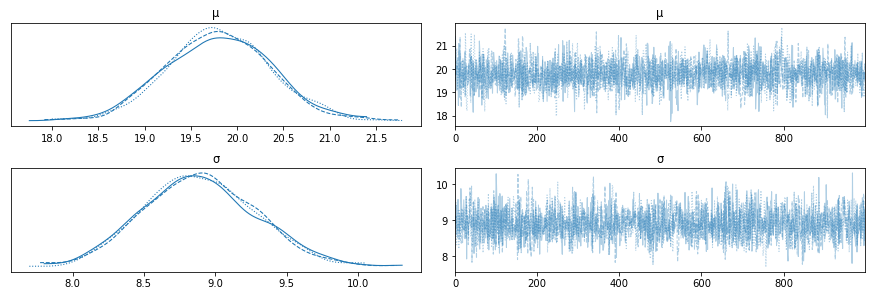

In [44]:
with pm.Model(coords=coords) as model:
    totalb = pm.Data("totalb", df.total_bill.values.astype(float))  #this is the key bit!
    tips = pm.Data("tips", df.total_bill.values.astype(float))
    sex = pm.Data("sex", df.sex.values.astype(int))
    #just model the tips - e.g. the target/response 
    μ = pm.Uniform('μ', lower=1, upper=50)
    σ = pm.HalfNormal('σ', sd=5)  # 10 is a LARGE value for the data
    y = pm.Normal('y', mu=μ, sd=σ, observed=tips)
    
    trace_pooled = pm.sample(1000, return_inferencedata=False)
az.plot_trace(trace_pooled)